In [1]:
import pandas
import numpy
import osgeo.gdal as gdal
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os.path
%matplotlib inline

In [2]:
imgPath = './pvimgs'

tilesOfInterest = [1475, 1239]#[1396, 1397, 1147]#[1397]#[2045]#70, 971, 972, 1211, 1212, 1213]

inImgs = []

for tile in tilesOfInterest:
    imgs = glob.glob(os.path.join(imgPath, '*_'+str(tile)+'.kea'))
    inImgs.extend(imgs)

print(inImgs)


['./pvimgs/PV2GMW_MangExtent_1845_14615_1475.kea', './pvimgs/PV2GMW_MangExtent_1835_14615_1239.kea']


In [3]:
startYear = 1987
endYear = 2016
years = numpy.arange(startYear, endYear+1, 1)


In [4]:
pxlCount = 0
for img in inImgs:
    dataset = gdal.Open(img, gdal.GA_ReadOnly)
    if not dataset:
        raise Exception("Could not open image: " + img)
    else:
        pxlCount = pxlCount + (dataset.RasterXSize * dataset.RasterYSize)
        if len(years) != dataset.RasterCount:
            raise Exception("Number of bands is not equal to the number of years")
        dataset = None


In [5]:
yearArrDict = dict()
for year in years:
    yearArrDict[year] = numpy.zeros(pxlCount)

imgPxlIdx = 0
for img in inImgs:
    dataset = gdal.Open(img, gdal.GA_ReadOnly)
    if not dataset:
        raise Exception("Could not open image: " + img)
    numPxl = dataset.RasterXSize * dataset.RasterYSize
    for bandIdx in range(dataset.RasterCount):
        band = dataset.GetRasterBand(bandIdx+1)
        #arrBand = band.ReadAsArray().flatten()
        yearArrDict[years[bandIdx]][imgPxlIdx:imgPxlIdx+numPxl] = band.ReadAsArray().flatten()
    imgPxlIdx = imgPxlIdx + numPxl

for year in yearArrDict:
    yearArrDict[year] = yearArrDict[year][yearArrDict[year] != 255]


In [6]:
#f, axarr = plt.subplots(len(years), sharex=True)

#f.set_figheight(60)

#idx = 0
#for year in years:
#    axarr[idx].hist(yearArrDict[year], 25, facecolor='green')#, alpha=0.75)normed=1
#    #axarr[idx].axis([0, 100, 0, 0.05])
#    axarr[idx].set_title(str(year))
#    idx = idx + 1


In [9]:

dataList = []
yearList = []
for year in years:
    dataArr = yearArrDict[year]
    dataList.append(dataArr)
    yearArr = numpy.zeros_like(dataArr, dtype=int)
    yearArr[...] = year
    yearList.append(yearArr)

dataArr = numpy.array(dataList).flatten()
yearArr = numpy.array(yearList).flatten()

yearDataDict = dict()
yearDataDict['year'] = yearArr
yearDataDict['x'] = dataArr
df = pandas.DataFrame.from_dict(yearDataDict, orient='columns')
#df

#df1 = df
#df1['year'] = years
#df2 = df.unstack()
#df2
#df.shape

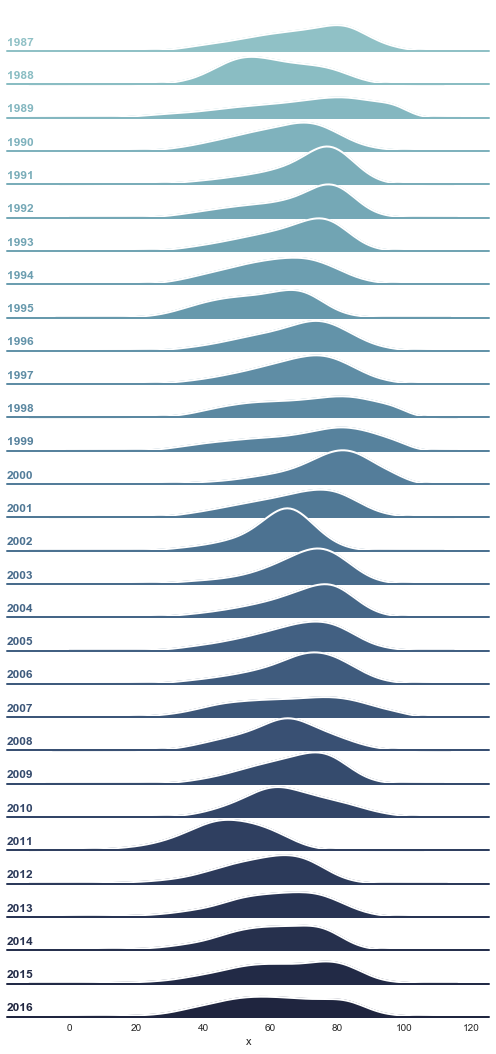

In [10]:
#import numpy as np
#import pandas as pd

sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(len(years), rot=-.25, light=.7)
g = sns.FacetGrid(df, row='year', hue='year', aspect=15, size=0.5, palette=pal)

g.map(sns.kdeplot, "x", clip_on=False, shade=True, alpha=1, lw=1.5, bw=4)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw=4)
g.map(plt.axhline, y=0, lw=2, clip_on=False)



# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color, 
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "x")


# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play will with overlap
g.set_titles("")
g.set(yticks=[])
#g.set(xticks=[])
#g.set_xlabels([])
g.despine(bottom=True, left=True)
